In [1]:
import pandas as pd
import wandb
from pathlib import Path
from src.utils import io_util
from src.utils import utils_helper
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_name="potter"
model_type="LM"
method="regression"
fmri_type="token"
extend_exp=""

In [3]:

api = wandb.Api()

method_name = "Procrustes Analysis" if method == "procrustes" else "Ridge Regression"
runs = api.runs(path=f"jalee/{data_name}-{fmri_type}-brain2{model_type}_{method}_averaged{extend_exp}")

model_tags = {
    "ft": "fasttext",
    "bert": "bert",
    "gpt2": "gpt2",
    "opt": "opt"
}
model_name_dict = {'bert_uncased_L-2_H-128_A-2': "BERT$_{\\textsc{TINY}}$",
            'bert_uncased_L-4_H-256_A-4': "BERT$_{\\textsc{MINI}}$" ,
            'bert_uncased_L-4_H-512_A-8': "BERT$_{\\textsc{SMALL}}$",
            'bert_uncased_L-8_H-512_A-8': "BERT$_{\\textsc{MEDIUM}}$",
            'bert-base-uncased': "BERT$_{\\textsc{BASE}}$",
            'bert-large-uncased': "BERT$_{\\textsc{LARGE}}$",
            'gpt2': "GPT2$_{\\textsc{BASE}}$",
            'gpt2-medium': "GPT2$_{\\textsc{MEDIUM}}$",
            'gpt2-large': "GPT2$_{\\textsc{LARGE}}$",
            'gpt2-xl': "GPT2$_{\\textsc{XL}}$",
            'opt-125m': "OPT$_{\\textsc{125M}}$",
            'opt-1.3b': "OPT$_{\\textsc{1.3B}}$",
            'opt-6.7b': "OPT$_{\\textsc{6.7B}}$",
        'opt-30b': "OPT$_{\\textsc{30B}}$",
            "fasttext":"fastText"}

df = pd.DataFrame()
for i, single_run in enumerate(runs):
    metric = json.load(single_run.file(single_run.summary["Results"]["path"]).download(exist_ok=True))
    df = pd.concat([df,pd.DataFrame(metric["data"], columns=metric["columns"])])

# # df['Subjects'] = df['Subjects'].replace({f'brain_{i}': f'Subject-{i}' for i in range(1, num_subs + 1)})
# df['Layers'] = df['Layers'].replace({f'layer_{i}': f'layer-{i})
# df['Models'] = df['Models'].replace(model_name_dict)
#
group_names = ["Models", "Layers"]
if extend_exp != "":
    group_names.append("Bins")
#
precision_csls, precision_nn = [], []
for k in [1, 5, 10, 30, 50, 100]:
    precision_csls.append(f'P@{k}-CSLS')
    precision_nn.append(f'P@{k}-NN')
#
precision = precision_csls + precision_nn
#

# id_order= [5,3,4,2,0,1,6,8,7,9,11,10,13,12]

layer_avg = df.groupby(group_names)[precision].mean().round(2).reset_index()
layer_avg = layer_avg.groupby(["Models"])[precision].max().round(2).reset_index()
# layer_avg = layer_avg.reindex(index=id_order)
# layer_avg.insert(loc=layer_avg.columns.get_loc("Models"), column="Summary",
#                     value=[f"Ave Max."])

#
group_names.append("Subjects")
layer_ = df.groupby(group_names)[precision].mean().round(2).reset_index()
# layer_max = layer_.groupby(["Models", "Layers", "Bins"])[precision].max().round(2).reset_index()
layer_max = layer_.groupby(["Models"])[precision].max().round(2).reset_index()
# layer_max = layer_max.reindex(index=id_order)
# layer_max.insert(loc=layer_max.columns.get_loc("Models"), column="Summary",
#                     value=[f"Single Max."])

layer_min = layer_.groupby(["Models"])[precision].min().reset_index()
# layer_min = layer_min.reindex(index=id_order)
# layer_min.insert(loc=layer_min.columns.get_loc("Models"), column="Summary",
#                     value=[f"Single Min."])


In [4]:
layer_max

,Models,P@1-CSLS,P@5-CSLS,P@10-CSLS,P@30-CSLS,P@50-CSLS,P@100-CSLS,P@1-NN,P@5-NN,P@10-NN,P@30-NN,P@50-NN,P@100-NN
0,bert-base-uncased,1.35,7.94,16.58,27.28,32.38,42.92,4.21,12.09,18.80,28.15,33.10,42.79
1,bert-large-uncased,1.08,5.76,11.96,25.23,31.44,40.24,4.21,7.45,16.70,25.34,31.34,41.63
2,bert_uncased_L-2_H-128_A-2,0.49,3.02,5.88,18.25,27.44,39.63,0.49,3.10,7.72,21.76,32.97,43.96
3,bert_uncased_L-4_H-256_A-4,0.08,2.06,3.33,8.02,13.70,25.77,0.18,7.19,7.80,12.78,17.84,29.05
4,bert_uncased_L-4_H-512_A-8,0.12,1.47,10.88,17.91,22.09,34.46,0.10,8.57,13.13,21.68,28.22,36.87
5,bert_uncased_L-8_H-512_A-8,0.10,5.92,11.05,24.52,28.28,35.75,4.21,8.13,14.35,24.89,28.71,37.20
6,fasttext,0.06,0.51,1.90,12.74,20.70,36.46,0.04,2.14,6.39,20.56,28.20,38.65
7,gpt2,0.49,2.74,4.25,11.80,15.95,29.93,0.16,2.43,3.55,13.52,17.56,33.18
8,gpt2-large,1.88,5.17,8.45,21.40,27.05,37.53,2.37,6.04,14.60,22.76,27.93,39.38
9,gpt2-medium,1.10,4.90,11.31,19.74,23.60,39.22,1.10,5.70,13.96,21.13,26.81,39.63


/tmp/ipykernel_27706/2152445377.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[rowid][model_type].set_xticklabels(x, rotation=65)
/tmp/ipykernel_27706/2152445377.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[rowid][model_type].set_xticklabels(x, rotation=65)
/tmp/ipykernel_27706/2152445377.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[rowid][model_type].set_xticklabels(x, rotation=65)


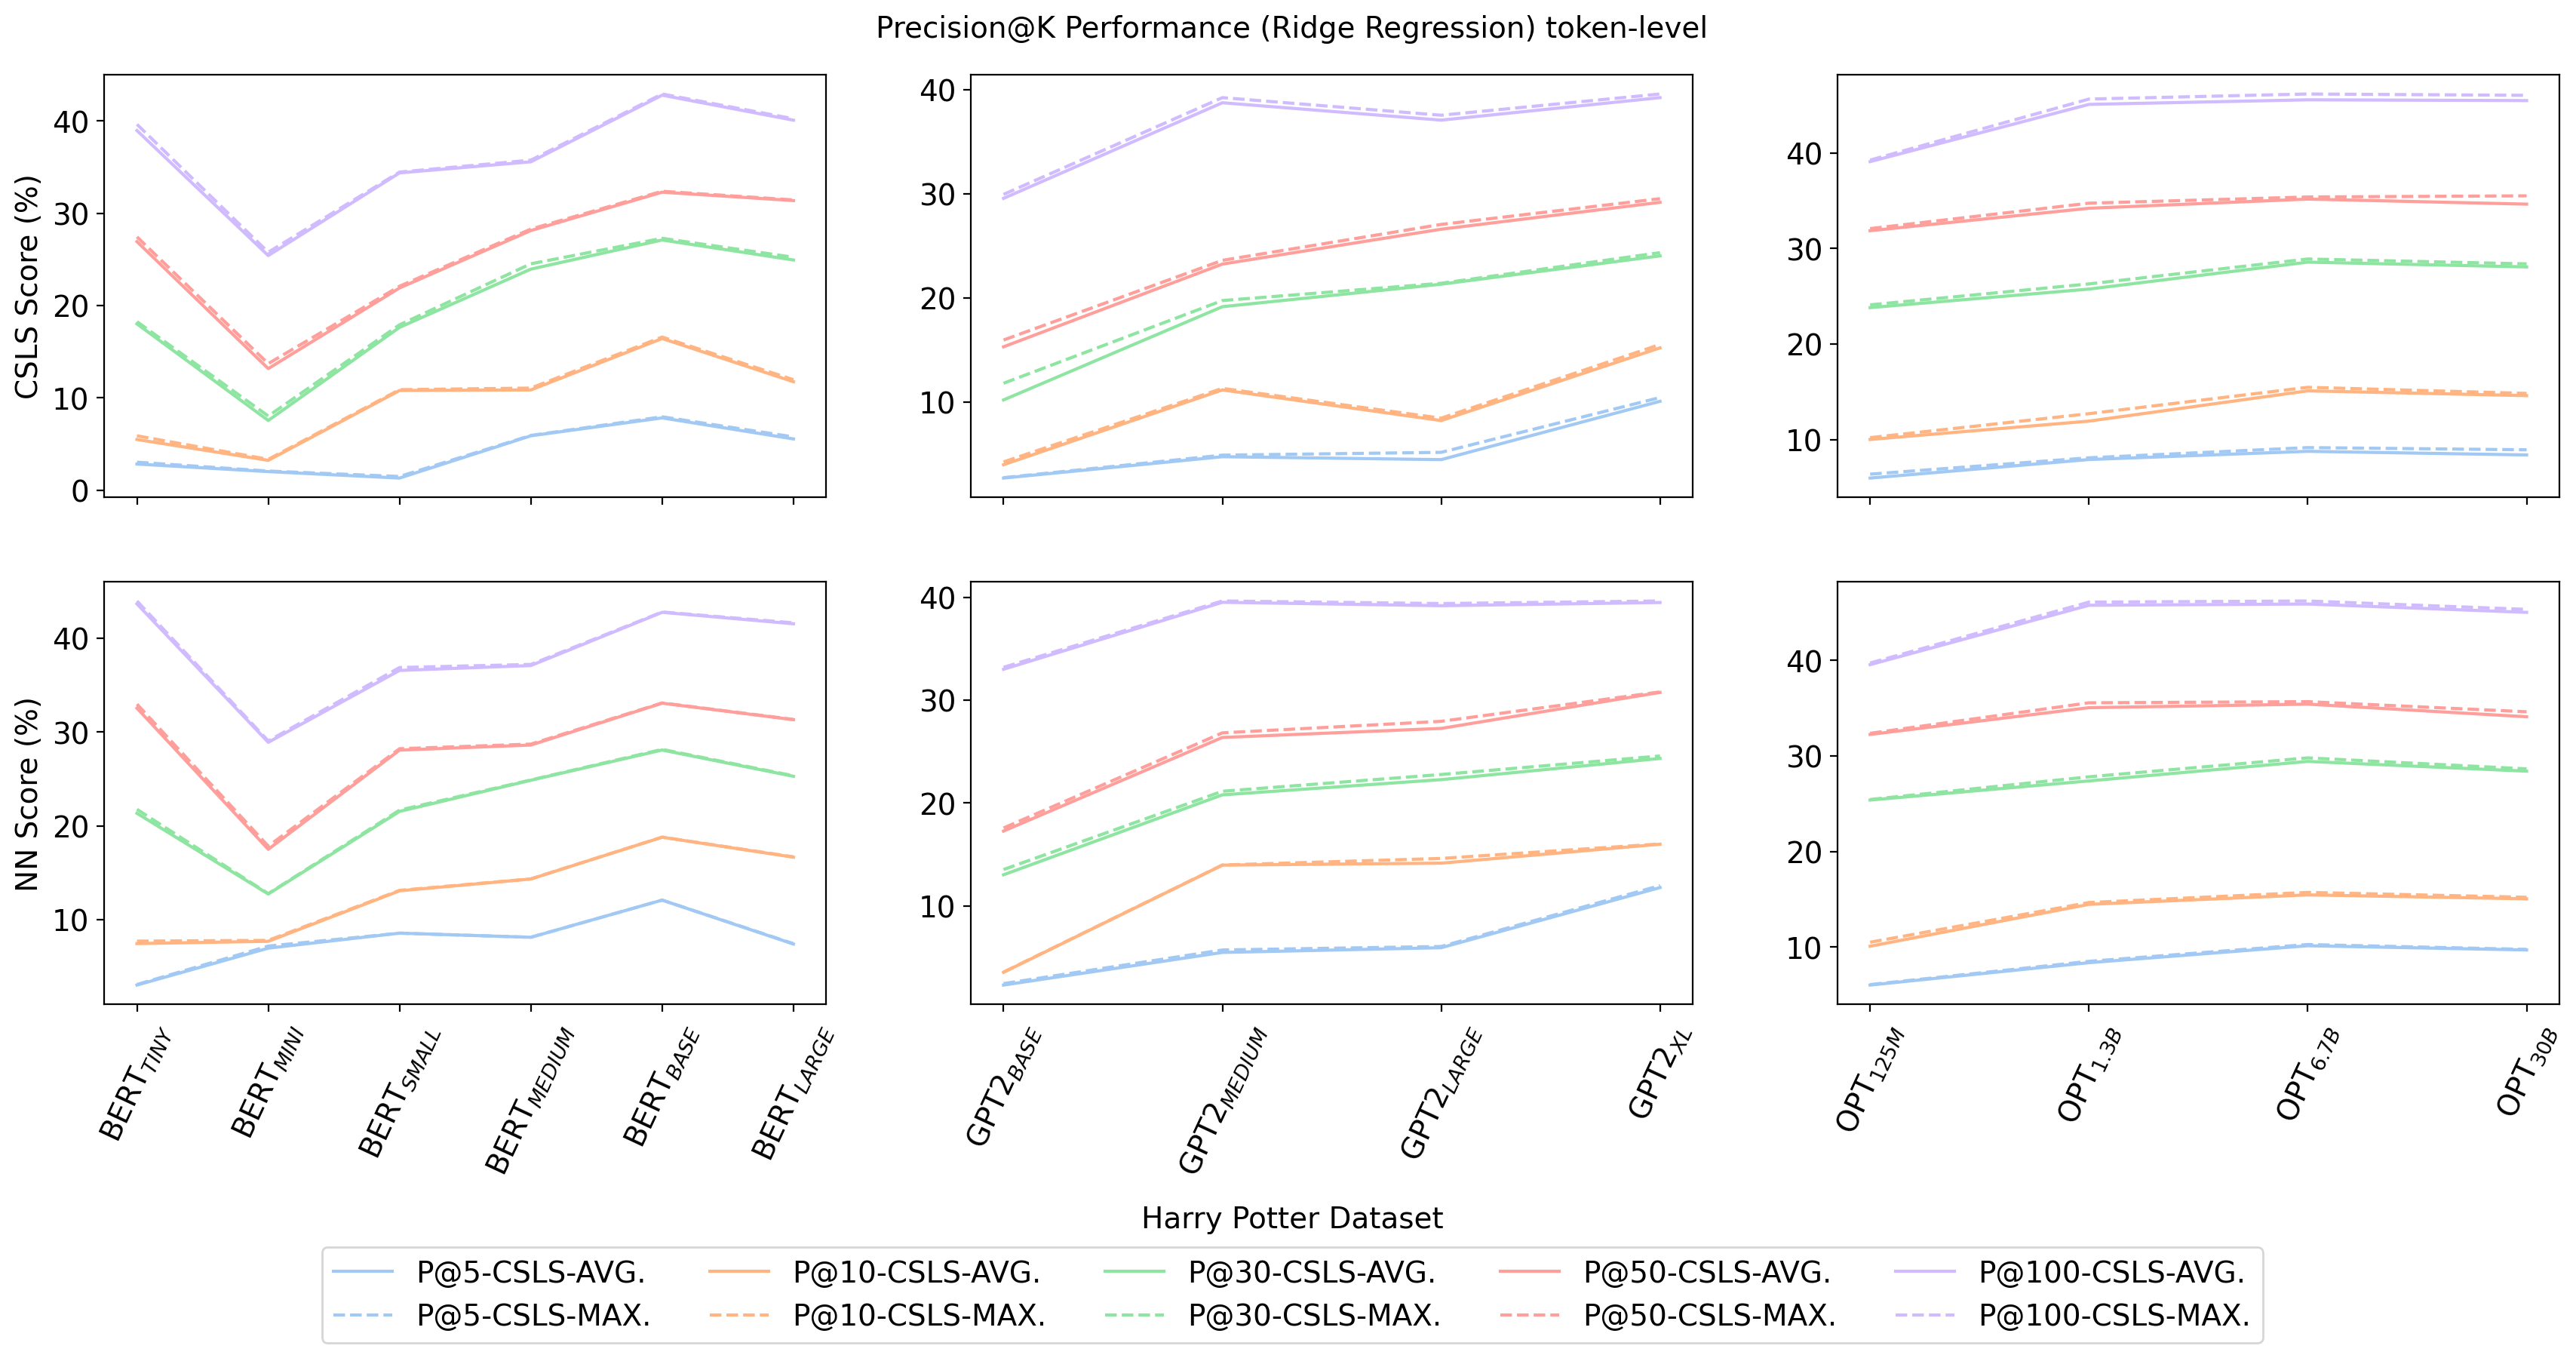

In [5]:
# plt.rcParams["font.family"] = "Times New Roman"
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=200, figsize =(21, 8), gridspec_kw = {'wspace':0.2, 'hspace':0.2})
# Define color palette
colors = sns.color_palette("pastel", 6)

# data_name = "Pereira"
data_name = "Harry Potter"
for rowid, nn_method in enumerate(["CSLS", "NN"]):
    for model_type, df in enumerate((df[:6], df[7:11],df[11:15])):
        if model_type == 0:
            x = [r"BERT$_{TINY}$", #4.4M
                r"BERT$_{MINI}$" , #11.3m
                r"BERT$_{SMALL}$", #29.1m
                r"BERT$_{MEDIUM}$", #41.7m
                r"BERT$_{BASE}$", #110m
                r"BERT$_{LARGE}$"] #340m
            model_name = "BERT"
            id_order = [2,3,4,5,0,1]
        elif model_type == 1:
            x = [r"GPT2$_{BASE}$", #117M
                r"GPT2$_{MEDIUM}$", #355M
                r"GPT2$_{LARGE}$", #762M
                r"GPT2$_{XL}$"] #1.5B
            model_name = "GPT2"
            # id_order = [0,2,1,3]
            id_order = [7,9,8,10]
            # id_order = [6,8,7,9]
        else:
            x = [r"OPT$_{125M}$", 
                r"OPT$_{1.3B}$",
                r"OPT$_{6.7B}$",
                r"OPT$_{30B}$"]
            model_name = "OPT"
            # id_order = [1,0,3,2]
            id_order = [12,11,14,13]
            # id_order = [11,10,13,12]

        save_dir = Path("./figures")
        save_dir.mkdir(parents=True, exist_ok=True)
        

        # Set the remaining columns as the Y-axis
        y_avg = layer_avg.reindex(index=id_order).iloc[:, 2:].round(2)
        y_max = layer_max.reindex(index=id_order).iloc[:, 2:].round(2)

        if nn_method == "CSLS":
            for idx, name in enumerate(y_avg.columns.values[0:5]):
                axs[rowid][model_type].plot(x, y_avg[name], label=f"{y_avg.columns.values[idx]}-AVG.", ls="-", color=colors[idx])
            for idx, name in enumerate(y_avg.columns.values[0:5]):
                axs[rowid][model_type].plot(x, y_max[name], label=f"{y_avg.columns.values[idx]}-MAX.", ls="--", color=colors[idx])
        else:
            for idx, name in enumerate(y_avg.columns.values[6:]):
                axs[rowid][model_type].plot(x, y_avg[name], label=f"{y_avg.columns.values[idx+6]}-AVG.", ls="-", color=colors[idx])
            for idx, name in enumerate(y_avg.columns.values[6:]):
                axs[rowid][model_type].plot(x, y_max[name], label=f"{y_avg.columns.values[idx+6]}-MAX.", ls="--", color=colors[idx])
        # Show the plot
        
        axs[rowid][model_type].tick_params(axis='y', labelsize=14)

        if model_type == 0:
            axs[rowid][model_type].set_ylabel(f"{nn_method} Score (%)",fontsize=14)
        if rowid == 1:
            axs[rowid][model_type].tick_params(axis='x', labelsize=14)
            axs[rowid][model_type].set_xticklabels(x, rotation=65)
        else:    
            axs[rowid][model_type].set_xticklabels([])
        # axs[rowid][model_type].set_xlabel("Model",fontsize=14)
        # i+=1
handles, labels = axs[0][0].get_legend_handles_labels()
order_list = [0, 5, 1,6, 2,7, 3,8, 4, 9]
# lines.extend(lines_01); labels.extend(labels_01)

fig.suptitle(f"Precision@K Performance ({method_name}) {fmri_type}-level",fontsize=14).set_position((0.5,0.93))
fig.supxlabel(f"{data_name} Dataset", fontsize=14).set_position((0.5, -0.08))
fig.legend([handles[i] for i in order_list], [labels[i] for i in order_list], bbox_to_anchor=(0., -.08, 1., -.102), loc='center', fancybox=True,
        ncol=5, borderaxespad=0., fontsize=14)
# plt.savefig(f'./{save_dir}/{data_name}-Models-{fmri_type}-{method}-all.pdf', bbox_inches='tight')
plt.show()

In [30]:
layer_avg.reindex(index=id_order).iloc[:, 2:].round(2)

,P@5-CSLS,P@10-CSLS,P@30-CSLS,P@50-CSLS,P@100-CSLS,P@1-NN,P@5-NN,P@10-NN,P@30-NN,P@50-NN,P@100-NN
12,22.62,32.70,44.92,50.21,58.64,0.18,22.32,32.06,44.69,49.80,58.34
11,37.67,51.67,66.22,70.71,76.33,0.14,37.44,51.83,65.87,70.38,76.99
14,42.78,57.11,69.06,73.47,78.19,0.50,42.28,57.41,69.15,73.29,78.29
13,46.72,59.14,70.08,72.68,76.09,2.63,46.45,58.89,69.43,72.72,76.19
